In [3]:
import numpy as np
from scipy.linalg import toeplitz

p = 12
n = 200
rho = 0.5

X = np.random.multivariate_normal(np.zeros(p, dtype="float64"),\
                                  toeplitz(rho ** np.arange(p)),\
                                  n)
beta = np.random.normal(0, 1, p)
y = np.dot(X, beta) + np.random.normal(0, 1, n)

In [4]:

alpha = 0.5
C = np.dot(X.T, X) + alpha * np.eye(p)
beta_est = np.linalg.solve(C, np.dot(X.T, y))

print(beta_est)
print(beta)

[-1.39177375 -0.45398115 -0.43534827  0.11153467 -0.63183783 -1.48206641
  0.78334917 -0.07417643  1.3568376   1.07122674  1.72470078  0.09138231]
[ -1.35030878e+00  -4.91065606e-01  -3.68082961e-01   1.42129743e-01
  -5.34203389e-01  -1.49558455e+00   6.63558627e-01   6.68265836e-04
   1.38412703e+00   1.14845778e+00   1.56490478e+00   2.91481947e-01]


In [5]:
p = 12
n = 200
rho = 0.5

def get_error_cond_X_beta_montecarlo(X, beta, alpha, nrun):
    
    n, p = X.shape
    y_mean = np.dot(X, beta)
    noise = np.random.normal(0, 1, (nrun, n))

    C = np.dot(X.T, X) + alpha * np.eye(p)
    v = np.dot(X.T, y_mean)
    beta_est = np.empty((nrun, p), dtype="float64")
    for irun in range(nrun):
        beta_est[irun] = np.linalg.solve(C, v + np.dot(X.T, noise[irun]))
                                                             
    bias = np.linalg.norm(beta_est.mean(axis=0) - beta) ** 2
    var = (np.linalg.norm(beta_est - beta_est.mean(axis=0)) ** 2) / nrun
    mse = bias + var

    return np.array((bias, var, mse))

def get_error_cond_X_montecarlo(X, alpha, n_beta=100, nrun=1000):
    
    n, p = X.shape
    beta = np.random.normal(0, 1, (n_beta, p))
    error = np.empty([n_beta, 3], dtype="float64")
    
    for i_beta in range(n_beta):
        error[i_beta] = get_error_cond_X_beta_montecarlo(X, beta[i_beta], alpha, nrun)
        
    return error.mean(axis=0)

def get_error_cond_X(X, alpha):
    n, p = X.shape
    
    XX = np.dot(X.T, X)
    C = XX + alpha * np.eye(p)
    bias = np.linalg.norm(np.linalg.solve(C, XX) - np.eye(p)) ** 2
    var = np.linalg.norm(np.linalg.solve(C, X.T)) ** 2
    mse = bias + var

    return np.array((bias, var, mse))

def get_error(alpha, p = 12, n = 200, rho = 0.5, n_X = 1000, n_montecarlo = None):
    
    n_alpha = len(alpha)
    error = np.empty([n_alpha, n_X, 3], dtype="float64")
    X = np.random.multivariate_normal(np.zeros(p, dtype="float64"),\
                                  toeplitz(rho ** np.arange(p)),\
                                  (n_X, n))
    if n_montecarlo is None:
        for i_alpha in range(n_alpha):
            for i_X in range(n_X):
                error[i_alpha, i_X] = get_error_cond_X(X[i_X], alpha[i_alpha])
    else:
        for i_alpha in range(n_alpha):
            for i_X in range(n_X):
                n_beta, nrun = n_montecarlo
                error[i_alpha, i_X] = get_error_cond_X_montecarlo(X[i_X], alpha[i_alpha],\
                                                                  n_beta, nrun)
        
    return error.mean(axis=1)

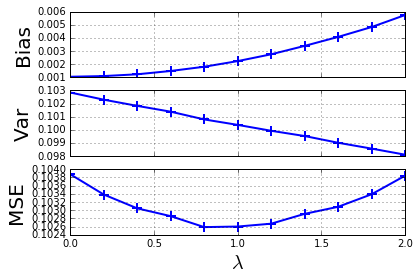

In [14]:
alpha = np.linspace(0.0, 2.0, 11)
# errors = get_error(alpha)
errors = get_error(alpha, n_X = 100, n_montecarlo=(200, 100))

import matplotlib.pyplot as plt
%matplotlib inline

axis_font = {'size':'20'}

fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(alpha, errors[:, 0], "+-", lw=2, markersize=10, markeredgewidth=2)
axs[0].set_ylabel("Bias", **axis_font)
axs[0].grid(True)
axs[1].plot(alpha, errors[:, 1], "+-", lw=2, markersize=10, markeredgewidth=2)
axs[1].set_ylabel("Var", **axis_font)
axs[1].grid(True)
axs[2].plot(alpha, errors[:, 2], "+-", lw=2, markersize=10, markeredgewidth=2)
axs[2].set_ylabel("MSE", **axis_font)
axs[2].set_xlabel("$\lambda$", **axis_font)
axs[2].grid(True)